<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250102%5D%20FL-DL%20MLP-CNN%20on%20UNSW-NB15%20with%20L2%3D0.01%20%26%20Dropout%3D0.2%20%26%20100%20Epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FL-DL // MLP-CNN model 10 classes on UNSW-NB15 with L2=0.01 & Dropout=0.2 & 100 Epochs**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [ ]:
# Load dataset
dataset = pd.read_csv("Dataset_10Classes.csv") #10 classes dataset

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [ ]:
dataset

,ID_Cb,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,Class
0,1,1,0.121478,tcp,-,FIN,6,4,258,172,...,1,0,0,0,1,1,0,Normal,0,0
1,2,2,0.649902,tcp,-,FIN,14,38,734,42014,...,2,0,0,0,1,6,0,Normal,0,0
2,3,3,1.623129,tcp,-,FIN,8,16,364,13186,...,3,0,0,0,2,6,0,Normal,0,0
3,4,4,1.681642,tcp,ftp,FIN,12,12,628,770,...,3,1,1,0,2,1,0,Normal,0,0
4,5,5,0.449454,tcp,-,FIN,10,6,534,268,...,40,0,0,0,2,39,0,Normal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,257669,82328,0.000005,udp,-,INT,2,0,104,0,...,2,0,0,0,2,1,0,Normal,0,0
257669,257670,82329,1.106101,tcp,-,FIN,20,8,18062,354,...,1,0,0,0,3,2,0,Normal,0,0
257670,257671,82330,0.000000,arp,-,INT,1,0,46,0,...,1,0,0,0,1,1,1,Normal,0,0
257671,257672,82331,0.000000,arp,-,INT,1,0,46,0,...,1,0,0,0,1,1,1,Normal,0,0


**Data Preprocessing**

In [ ]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

In [ ]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [93000  2677  2329 16353 44525 24246 58871 13987  1511   174]


In [ ]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
!pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4


**Data Balancing utilized SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [93000 93000 93000 93000 93000 93000 93000 93000 93000 93000]


**Split data into 80% Training and 20% Testing**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

**Hybrid MLP-CNN with L2=0.01 & Dropout=0.2 & 100 Epochs**

In [ ]:
from keras.layers import Dense, Dropout, Reshape, Conv1D
from keras.regularizers import l2
from keras.layers import Reshape
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Convert target to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=10)  # Change to 10 classes
y_test = to_categorical(y_test, num_classes=10)

# Define the hybrid MLP + CNN model with regularization and other techniques to reduce overfitting
def build_hybrid_model(input_shape, num_classes):
    model = Sequential()

    # MLP layers with L2 regularization
    model.add(Dense(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))  # Increased dropout
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))

    # Reshape output for CNN layer
    model.add(Reshape((64, 1)))  # Reshape to (batch_size, timesteps=64, features=1)

    # CNN layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())

    # Dense layers for final feature extraction
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))

    # Output layer with softmax activation for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build and compile the model
input_shape = (X_train.shape[1], )
num_classes = y_train.shape[1]
model = build_hybrid_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train the model with early stopping
#from keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Before fitting the model, ensure y_train and y_test have the correct shape:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
assert y_train.shape[1:] == (10,), "y_train shape incorrect"
assert y_test.shape[1:] == (10,), "y_test shape incorrect"

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    #callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


y_train shape: (744000, 10)
y_test shape: (186000, 10)
Epoch 1/100
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 88s 4ms/step - accuracy: 0.9279 - loss: 0.4954 - val_accuracy: 0.9958 - val_loss: 0.1511
Epoch 2/100
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 86s 4ms/step - accuracy: 0.9847 - loss: 0.1996 - val_accuracy: 0.9989 - val_loss: 0.1239
Epoch 3/100
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 86s 4ms/step - accuracy: 0.9858 - loss: 0.1945 - val_accuracy: 0.9969 - val_loss: 0.1469
Epoch 4/100
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 87s 4ms/step - accuracy: 0.9856 - loss: 0.1928 - val_accuracy: 0.9975 - val_loss: 0.1378
Epoch 5/100
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 88s 4ms/step - accuracy: 0.9860 - loss: 0.1893 - val_accuracy: 0.9964 - val_loss: 0.1441
Epoch 6/100
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 89s 4ms/step - accuracy: 0.9853 - loss: 0.1898 - val_accuracy: 0.9977 - val_loss: 0.1497
Epoch 7/100
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 87s 4ms/step - accuracy: 0.9861 - loss: 0.1862 - val_accuracy: 0.9969 - val_loss: 0.1314
Epoch 8

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

Accuracy: 0.9916397849
Precision: 0.9917161462
Recall: 0.9916397849
F1-Score: 0.9916283197


In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

5813/5813 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Accuracy: 0.9916397849
Precision: 0.9917161462
Recall: 0.9916397849
F1-Score: 0.9916283197


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[18593     2     0     0     0     0     0     3     2     0]
 [    0 18588    12     0     0     0     0     0     0     0]
 [    0     0 18600     0     0     0     0     0     0     0]
 [    0    52   119 18428     1     0     0     0     0     0]
 [    0    53    51   721 17769     6     0     0     0     0]
 [    3     0     6     7   453 18129     2     0     0     0]
 [    0     2     2     5     8    13 18557    13     0     0]
 [    0     1     3     0     0     0     0 18581    15     0]
 [    0     0     0     0     0     0     0     0 18600     0]
 [    0     0     0     0     0     0     0     0     0 18600]]


In [ ]:
# Detection Rate (Recall for each class)
print("Detection Rates per Class:", recall_score(y_true_classes, y_pred_classes, average=None))

Detection Rates per Class: [0.99962366 0.99935484 1.         0.99075269 0.95532258 0.97467742
 0.99768817 0.99897849 1.         1.        ]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Import roc_curve
from sklearn.metrics import roc_curve # This line imports the roc_curve function
from sklearn.metrics import auc # This line imports the auc function
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib as plt

# After training, calculate ROC curves and AUC for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.10f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")

# Save the plot as a high-resolution image
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.close()

# Calculate and print AUC scores for each class
print("\nAUC Scores for each class:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.10f}")

# Calculate macro-average AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-average AUC: {macro_roc_auc:.10f}")

<ipython-input-15-c5170017384f>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))



AUC Scores for each class:
Class 0: 0.9999999926
Class 1: 0.9999575720
Class 2: 0.9999815401
Class 3: 0.9995824956
Class 4: 0.9975043356
Class 5: 0.9999176154
Class 6: 0.9998772389
Class 7: 0.9998236700
Class 8: 0.9999399165
Class 9: 1.0000000000

Macro-average AUC: 0.9996584377


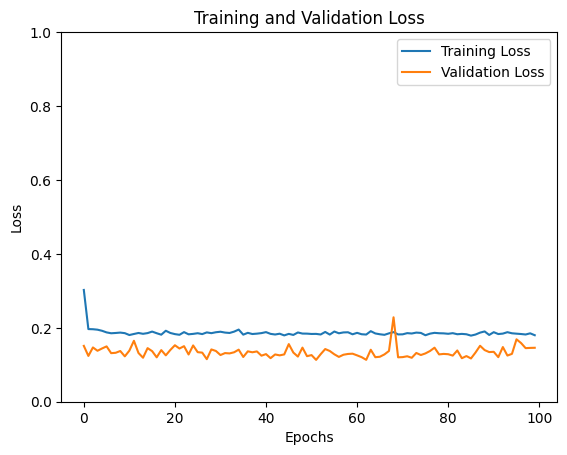

In [ ]:
# Plot Training and Validation Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis scale to 1
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="PuBu",
                 vmin=0, vmax=35000, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
  ax.yaxis.set_ticklabels(['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid MLP-CNN Model


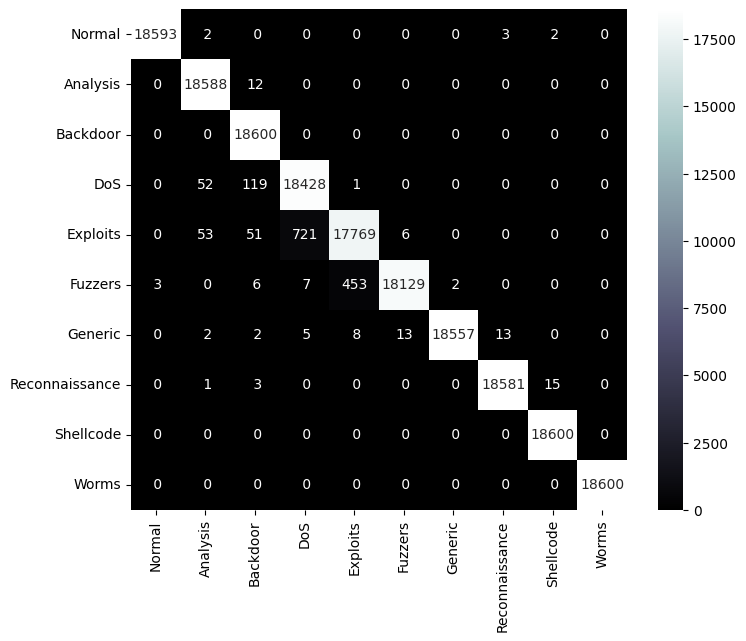

In [ ]:
print("Confusion Matrix of Hybrid MLP-CNN Model")
#conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6.5))
# Use plt.xticks to set custom tick labels
# Using get_xticklabels() to access the current labels and then setting rotation.
plt.xticks(ticks=np.arange(10), labels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'], rotation=45)
plt.yticks(ticks=np.arange(10), labels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'], rotation=45)
sns.heatmap(conf_matrix, annot=True, fmt='2', cmap='bone',xticklabels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'],
            yticklabels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
sns.set(font_scale=1)
plt.show() # Display the heatmap

In [ ]:
def conf_mat(d1,d2):
  cm = confusion_matrix(y_true_classes, y_pred_classes)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="gist_yarg",
                 vmin=0, vmax=5600, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=0.8)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
  ax.yaxis.set_ticklabels(['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
  plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Federated DL// MLP-CNN Model


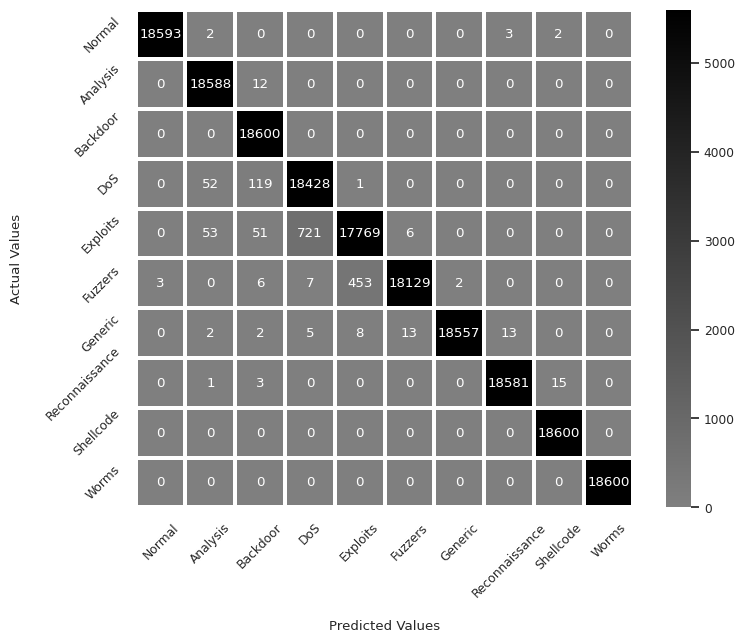

In [ ]:
print("Confusion Matrix of Federated DL// MLP-CNN Model")
conf_mat(y_true_classes, y_pred_classes)